In [3]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Flatten, Dense, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report 

In [4]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('/kaggle/input/fakereal-logo-detection-dataset/file_mapping.csv')

# Display the columns to check if 'Unnamed: 0' is present
print("Columns before dropping 'Unnamed: 0':", df.columns)

# Drop 'Unnamed: 0' if it exists
if 'Unnamed: 0' in df.columns:
    df.drop('Unnamed: 0', axis=1, inplace=True)
    print("Column 'Unnamed: 0' dropped.")
else:
    print("Column 'Unnamed: 0' not found in DataFrame.")

# Display the first few rows of the DataFrame
df.head()


Columns before dropping 'Unnamed: 0': Index(['Filename', 'Brand Name', 'Label', 'Tagline'], dtype='object')
Column 'Unnamed: 0' not found in DataFrame.


,Filename,Brand Name,Label,Tagline
0,output\Cowbell\000001.jpg,Cowbell,Genuine,sooo creamy sooo gooood
1,genLogoOutput\Rolex\000003.jpg,Rolex,Fake,antiophthalmic_factor crown for every accompli...
2,output\PlayStation\000005.jpg,PlayStation,Genuine,eNoS Lives.
3,output\YouTube\000004.jpg,YouTube,Genuine,Broadcast Yourself
4,genLogoOutput\Lays\000004.jpg,Lays,Fake,eNoS sprightliness .


In [5]:
# Preprocess the image 
label_encoder = preprocessing.LabelEncoder()
df['Label'] = label_encoder.fit_transform(df['Label'])

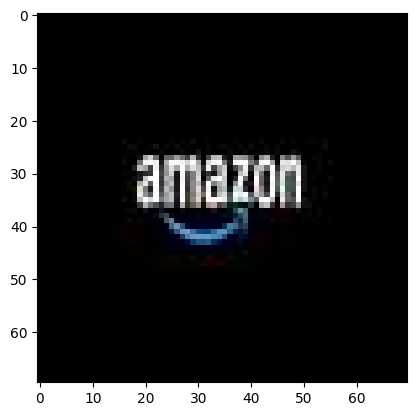

In [6]:
img = cv2.imread(os.path.join('/kaggle/input/fakereal-logo-detection-dataset', df['Filename'][6].replace('\\', '/')), cv2.COLOR_RGB2BGR)
plt.imshow(img)

In [7]:
IMG_SIZE = 70
images = []
labels = []

for _, row in df.iterrows():
    img = cv2.imread(os.path.join('/kaggle/input/fakereal-logo-detection-dataset',
                                  row['Filename'].replace('\\', '/')), )
    try:
        img_arr = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        image = img_to_array(img_arr)
        image = preprocess_input(image)
        images.append(image)
        labels.append(row['Label'])
    except:
        continue
image_shape = images[0].shape

for image in images:
    if image.shape != image_shape:
        raise ValueError("All images must have the same shape.")

images = np.array(images)
labels = np.array(labels)

In [8]:
# Normalize pixel values to the range [0, 1]
images = np.array(images) / 255.0


In [9]:
# Split the dataset into train and test sets

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)
test_labels

array([1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0])

In [10]:
# Build the model 
base_model = tf.keras.applications.MobileNet(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=output)

17225924/17225924 [==============================] - 0s 0us/step


In [11]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 70, 70, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 35, 35, 32)        864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 35, 35, 32)        128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 35, 35, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 35, 35, 32)        288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 35, 35, 32)        128   

In [12]:
# Train the model with EarlyStopping
early_stopping = EarlyStopping(monitor="val_loss", patience=5, verbose=1, restore_best_weights=True)
model.fit(train_images, train_labels, batch_size=32, epochs=10, validation_data=(test_images, test_labels), callbacks=[early_stopping])

Epoch 1/10
21/21 [==============================] - 17s 404ms/step - loss: 0.6730 - accuracy: 0.6712 - val_loss: 0.6599 - val_accuracy: 0.6242
Epoch 2/10
21/21 [==============================] - 8s 374ms/step - loss: 0.2521 - accuracy: 0.9000 - val_loss: 0.7467 - val_accuracy: 0.6242
Epoch 3/10
21/21 [==============================] - 7s 357ms/step - loss: 0.1344 - accuracy: 0.9455 - val_loss: 0.9130 - val_accuracy: 0.6242
Epoch 4/10
21/21 [==============================] - 8s 358ms/step - loss: 0.1095 - accuracy: 0.9652 - val_loss: 0.8522 - val_accuracy: 0.6242
Epoch 5/10
21/21 [==============================] - 8s 359ms/step - loss: 0.0565 - accuracy: 0.9909 - val_loss: 1.4715 - val_accuracy: 0.6242
Epoch 6/10
21/21 [==============================] - 8s 381ms/step - loss: 0.0406 - accuracy: 0.9894 - val_loss: 1.6564 - val_accuracy: 0.6242
Epoch 6: early stopping


In [13]:
# Evaluate the model
_, accuracy = model.evaluate(test_images, test_labels)
print('Test Accuracy:', accuracy)

6/6 [==============================] - 0s 50ms/step - loss: 0.6599 - accuracy: 0.6242
Test Accuracy: 0.6242424249649048


In [14]:
# Predictions
predictions = model.predict(test_images)
y_pred = (predictions > 0.5).astype(int).reshape(-1)

6/6 [==============================] - 1s 46ms/step


In [15]:
print(classification_report(y_pred, test_labels))

              precision    recall  f1-score   support

           0       1.00      0.62      0.77       165
           1       0.00      0.00      0.00         0

    accuracy                           0.62       165
   macro avg       0.50      0.31      0.38       165
weighted avg       1.00      0.62      0.77       165



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
image_path="/kaggle/input/bmw-image"
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    try:
        img_arr = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        image = img_to_array(img_arr)
        image = preprocess_input(image)
        return image
    except Exception as e:
        print(f"Error preprocessing image: {e}")
        return None

In [17]:
def predict_image(model, image_path):
    # Preprocess the image
    image = preprocess_image(image_path)
    if image is not None:
        # Expand dimensions to match the model's expected input shape
        image = np.expand_dims(image, axis=0)

        # Make prediction
        prediction = model.predict(image)

        # Convert prediction to binary (0 or 1)
        predicted_class = int(prediction > 0.5)

        return predicted_class
    else:
        return None


In [18]:

# Test the model with user input
user_image_path = input("Enter the path of the image to test: ")
predicted_class = predict_image(model, user_image_path)

if predicted_class is not None:
    if predicted_class == 1:
        print("The model predicts the image is Genuine.")
    else:
        print("The model predicts the image is Fake.")
else:
    print("Error processing the image.")

Enter the path of the image to test:  /kaggle/input/fakereal-logo-detection-dataset/output/Apple/000001.jpg


1/1 [==============================] - 0s 29ms/step
The model predicts the image is Genuine.
